In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from random import uniform
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
class BranchNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(BranchNetwork, self).__init__()
        hidden_channle = 60
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.ReLU(),
            nn.Linear(hidden_channle, hidden_channle), nn.ReLU(),
            nn.Linear(hidden_channle, hidden_channle), nn.ReLU(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self, x):
        x=self.net(x)
        return x

class TrunkNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TrunkNetwork, self).__init__()
        hidden_channle = 60
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.ReLU(),
            nn.Linear(hidden_channle, hidden_channle), nn.ReLU(),
            nn.Linear(hidden_channle, hidden_channle), nn.ReLU(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self, x):
        x=self.net(x)
        return x

class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, output_dim):
        super(DeepONet, self).__init__()
        self.branch_net = BranchNetwork(branch_input_dim, output_dim)
        self.trunk_net = TrunkNetwork(trunk_input_dim, output_dim)

    def forward(self, branch_input, trunk_input):
        #print(branch_input.shape,trunk_input.shape)
        branch_output = self.branch_net(branch_input)
        #print(branch_output.shape)
        trunk_output = self.trunk_net(trunk_input)
        #print(trunk_output.shape)
        G = torch.matmul(branch_output, trunk_output.t())
        G = G.T
        #print(G.shape,'\n\n')
        return G

In [3]:
def Get_u(num, max_degree, seed= None):
    if seed:
        np.random.seed(seed)
    polynomials = []
    for _ in range(num):
        # 多项式的次数
        degree = np.random.randint(1, max_degree + 1)
        # 多项式的系数 [-10, 10]
        coefficients = np.random.randint(-10, 11, size=degree + 1)

        polynomial = np.poly1d(coefficients)
        polynomials.append(polynomial)
    return polynomials
def Get_u_x(polynomials, x):
    results = np.zeros((len(polynomials), x.shape[0]))

    for i, poly in enumerate(polynomials):
        results[i, :] = poly(x.flatten())  # 使用flatten将x转为一维数组

    return results
# 积分
def Get_fu(polynomials):
    integrals = []
    for poly in polynomials:
        integral = poly.integ()
        integrals.append(integral)

    return integrals
N_u = 500
N_x = 100
N_y = 20
polynomials = Get_u(N_u, max_degree = 5) # N_u个max_degree次常系数多项式
f_polynomials = Get_fu(polynomials)

x_train = np.linspace(0, 1, N_x)
ux_train = Get_u_x(polynomials, x_train)

y_train = np.random.random((N_y,1))
g_train = Get_u_x(f_polynomials, y_train).T
model = DeepONet(N_x, 1, 100)

[Epoch 1/20000] [loss: 17.05971908569336]
[Epoch 501/20000] [loss: 0.017646268010139465]
[Epoch 1001/20000] [loss: 0.007154328282922506]
[Epoch 1501/20000] [loss: 0.022603774443268776]
[Epoch 2001/20000] [loss: 0.0038990231696516275]
[Epoch 2501/20000] [loss: 0.04424913972616196]
[Epoch 3001/20000] [loss: 0.04854077473282814]
[Epoch 3501/20000] [loss: 0.03758084401488304]
[Epoch 4001/20000] [loss: 0.04045335575938225]
[Epoch 4501/20000] [loss: 0.001874816487543285]
[Epoch 5001/20000] [loss: 0.07418137788772583]
[Epoch 5501/20000] [loss: 0.025584734976291656]
[Epoch 6001/20000] [loss: 0.018647370859980583]
[Epoch 6501/20000] [loss: 0.013246653601527214]
[Epoch 7001/20000] [loss: 0.009998916648328304]
[Epoch 7501/20000] [loss: 0.006874025799334049]
[Epoch 8001/20000] [loss: 0.005334291607141495]
[Epoch 8501/20000] [loss: 0.003904670709744096]
[Epoch 9001/20000] [loss: 0.003013976849615574]
[Epoch 9501/20000] [loss: 0.002526942640542984]
[Epoch 10001/20000] [loss: 0.0020103829447180033]
[

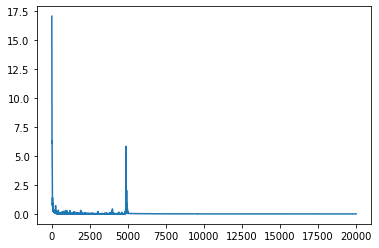

In [4]:
x = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
u = torch.tensor(ux_train, dtype=torch.float32, requires_grad=True)
y = torch.tensor(y_train, dtype=torch.float32, requires_grad=True)
g = torch.tensor(g_train, dtype=torch.float32, requires_grad=True)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)
epochs = 20000
Losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    G = model(u, y)
    loss = torch.mean((G-g)**2)
    loss.backward()
    Losses.append(loss.item())
    if epoch % 500 ==0:
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
    optimizer.step()
    scheduler.step()
plt.plot(Losses)
plt.show()

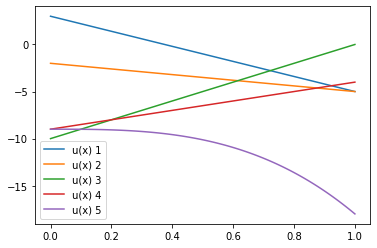

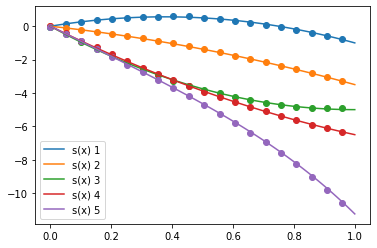

Error 1 = 0.0008903957734383793
Error 2 = 0.00020725874215547928
Error 3 = 0.002050855693857951
Error 4 = 0.00039867285505537837
Error 5 = 0.0012237185626777797
Average Error = 0.0009541803254369934


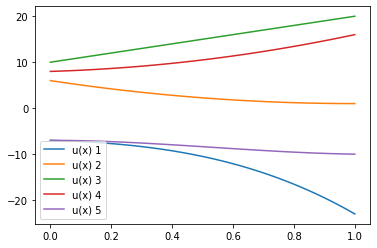

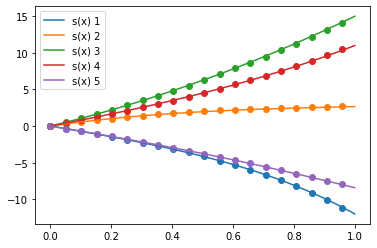

Error 1 = 0.0008720070724720204
Error 2 = 0.0038583319458774866
Error 3 = 0.004381625521628442
Error 4 = 0.002019383582093603
Error 5 = 0.0003177525686919686
Average Error = 0.0022898201381527034


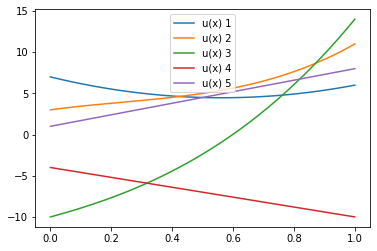

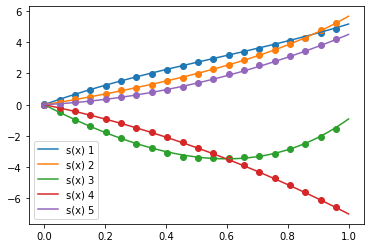

Error 1 = 0.0019987806911316575
Error 2 = 0.0004234759389180594
Error 3 = 0.004872161589788837
Error 4 = 0.0008268202317046885
Error 5 = 0.001070783362695352
Average Error = 0.001838404362847719


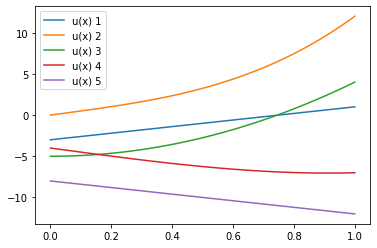

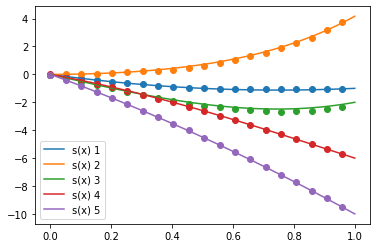

Error 1 = 0.0006811082739220476
Error 2 = 0.004313926145348183
Error 3 = 0.015618844403634891
Error 4 = 0.0002603727489974195
Error 5 = 0.0006143304718314289
Average Error = 0.004297716408746793


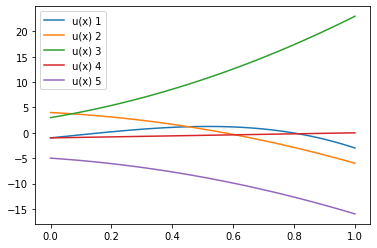

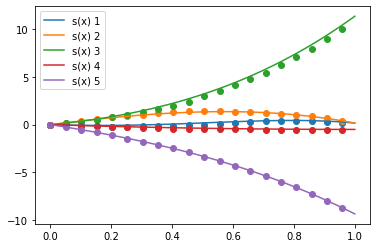

Error 1 = 0.015328452291428247
Error 2 = 0.001811173776100462
Error 3 = 0.08474483732603824
Error 4 = 0.004227386705984254
Error 5 = 0.0003360773946179284
Average Error = 0.021289585498833828


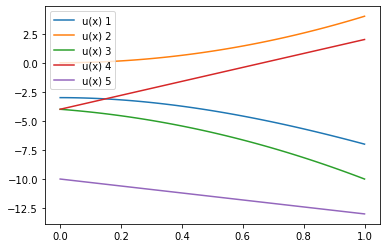

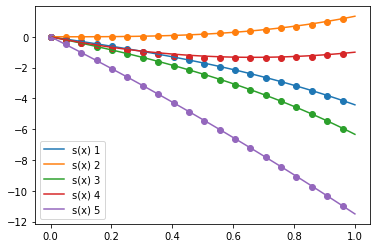

Error 1 = 0.00045227013099669283
Error 2 = 0.0008999888344318691
Error 3 = 0.00019504914560077157
Error 4 = 0.004256969380434155
Error 5 = 0.00022929229851775007
Average Error = 0.0012067139579962478


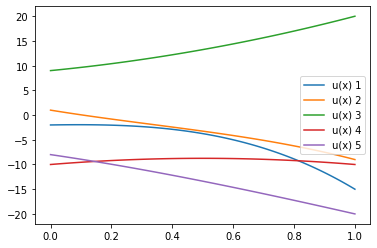

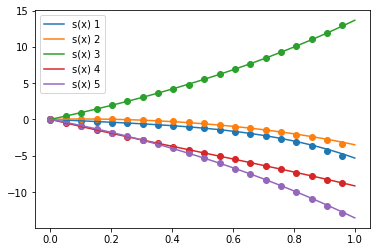

Error 1 = 0.014199681595387781
Error 2 = 0.005056955442025175
Error 3 = 0.0010961686980519817
Error 4 = 0.0004725664286321416
Error 5 = 0.0032352988330444517
Average Error = 0.0048121341994283055


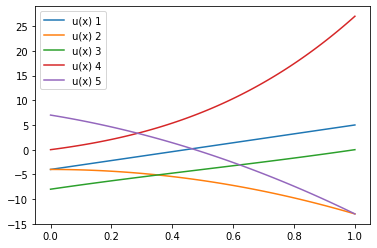

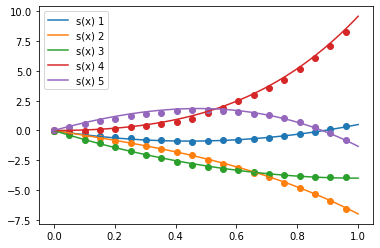

Error 1 = 0.0012070107953466775
Error 2 = 0.001322427001951207
Error 3 = 0.001924563631147654
Error 4 = 0.02629037812968955
Error 5 = 0.015631090560647817
Average Error = 0.009275094023756581


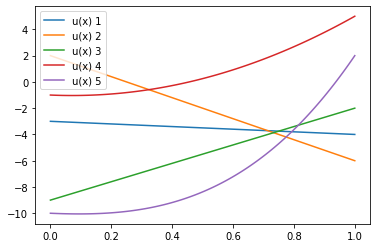

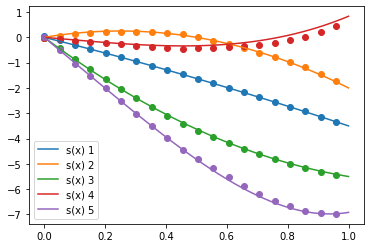

Error 1 = 0.00018223049040033432
Error 2 = 0.0009563023009889918
Error 3 = 0.0007402425388164572
Error 4 = 0.017640727010169485
Error 5 = 0.003870916470546365
Average Error = 0.0046780837621843265


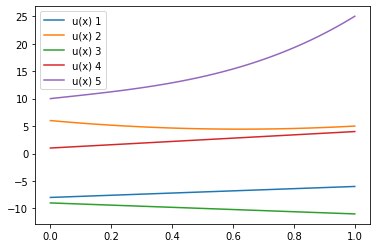

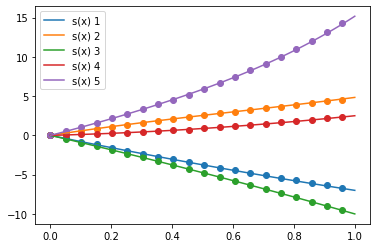

Error 1 = 0.003033757104272947
Error 2 = 0.0013424221841046285
Error 3 = 0.00036678996858069293
Error 4 = 0.0002865564945825013
Error 5 = 0.0019730751776147358
Average Error = 0.001400520185831101


In [5]:
def test(num = 5):
    polynomials = Get_u(num, 3)
    x = np.linspace(0, 1, N_x)
    ux_test = Get_u_x(polynomials, x)
    sx_test = Get_u_x(Get_fu(polynomials),x)
    for i in range(num):
        plt.plot(x,ux_test[i],label='u(x) '+ str(i+1))
    plt.legend()
    plt.show()

    u_test = torch.tensor(ux_test, dtype=torch.float32, requires_grad=True)
    y_test = torch.tensor(x.reshape(-1,1), dtype=torch.float32, requires_grad=True)
    s_pre = model(u_test,y_test)
    s_pre = s_pre.detach().numpy()
    for i in range(num):
        plt.plot(x,sx_test[i],label='s(x) '+ str(i+1))
        plt.scatter(x[::5],s_pre[:,i][::5])
    plt.legend()
    plt.show()
    Error = []
    for i in range(num):
        error = np.mean((s_pre[:,i] - sx_test[i,:])**2)
        Error.append(error)
        print(f'Error {i+1} = {error}')
    print(f'Average Error = {np.mean(Error)}')
for i in range(10):
    test()